In [1]:
rating_data_raw = sc.textFile("ml-100k/u.data")
print rating_data_raw.first()
num_ratings = rating_data_raw.count()
print "Ratings %d" % num_ratings

user_data = sc.textFile("ml-100k/u.user")
num_users = user_data.count()
print "Users %d" % num_users

movie_data = sc.textFile("ml-100k/u.item")
num_movies = movie_data.count()
print "Movies %d" % num_movies


196	242	3	881250949
Ratings 100000
Users 943
Movies 1682


In [2]:
import numpy as np

rating_data = rating_data_raw.map(lambda line: line.split("\t"))
ratings = rating_data.map(lambda fields: int(fields[2]))
max_rating = ratings.reduce(lambda x, y: max(x, y))
min_rating = ratings.reduce(lambda x, y: min(x, y))
mean_rating = ratings.reduce(lambda x, y: x + y) / num_ratings
median_rating = np.median(ratings.collect())
ratings_per_user = num_ratings / num_users
ratings_per_movie = num_ratings / num_movies
print "Min rating %d" % min_rating
print "Max rating %d" % max_rating
print "Average rating: %2.2f" % mean_rating
print "Median rating: %d" % median_rating
print "Average # of ratings per uses: %2.2f" % ratings_per_user
print "Average # of ratings per movie: %2.2f" % ratings_per_movie

Min rating 1
Max rating 5
Average rating: 3.00
Median rating: 4
Average # of ratings per uses: 106.00
Average # of ratings per movie: 59.00


In [6]:
print ratings.stats()

(count: 100000, mean: 3.52986, stdev: 1.12566797076, max: 5.0, min: 1.0)


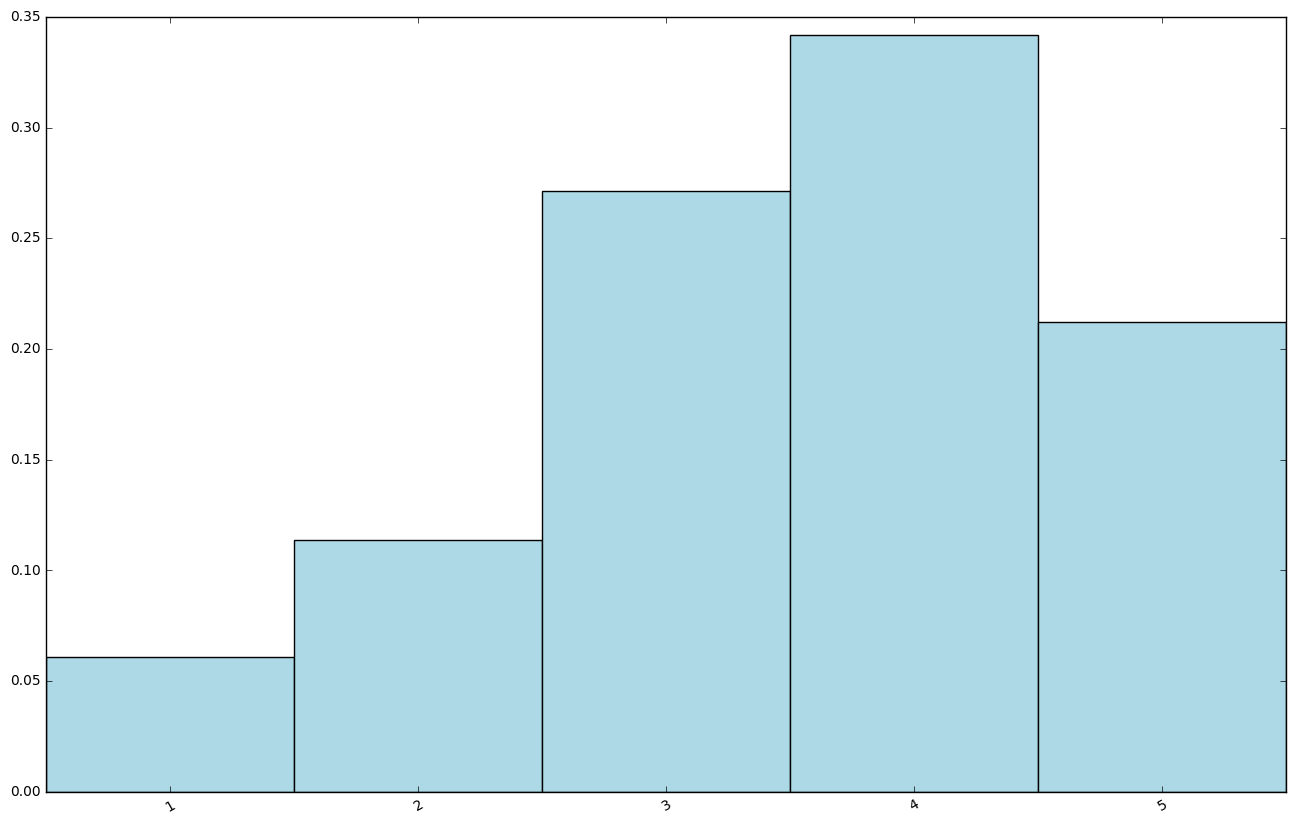

In [3]:
import matplotlib.pyplot as plt

count_by_rating = ratings.countByValue()
x_axis = np.array(count_by_rating.keys())
y_axis = np.array([float(c) for c in count_by_rating.values()])
#We normalize the y-axis here to percentages
y_axis_normed = y_axis / y_axis.sum()
pos = np.arange(len(x_axis))
width = 1.0

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=30)
fig = plt.gcf()
fig.set_size_inches(16, 10)
plt.show()

In [5]:
user_ratings_grouped = rating_data.map(lambda fields: (int(fields[0]), int(fields[2]))).groupByKey()
user_ratings_byuser = user_ratings_grouped.map(lambda (k, v): (k, len(v)))
print user_ratings_byuser.take(5)

[(2, 62), (4, 24), (6, 211), (8, 59), (10, 184)]


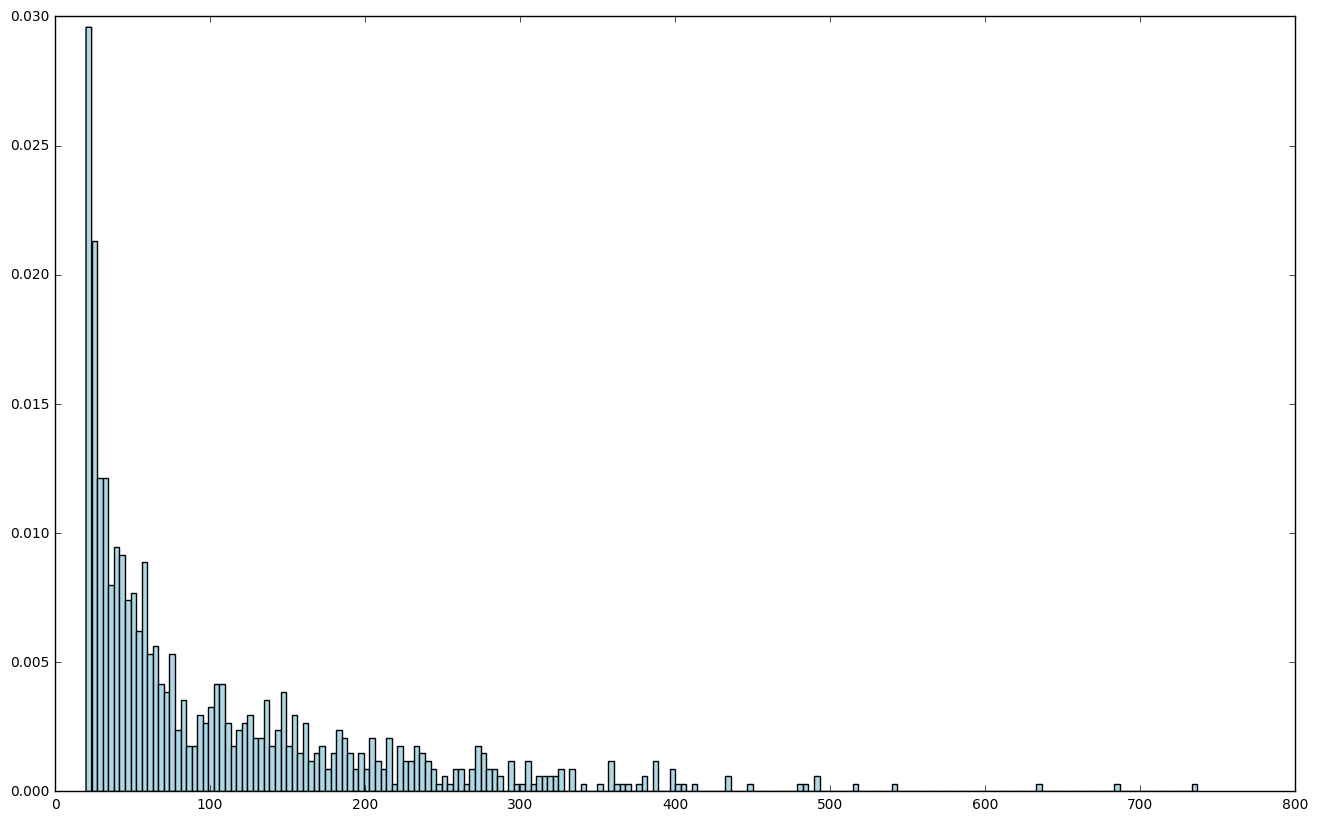

In [6]:
user_ratings_byuser_local = user_ratings_byuser.map(lambda (k, v):  v).collect()
plt.hist(user_ratings_byuser_local, bins=200, color='lightblue', normed=True)
fig = plt.gcf()
fig.set_size_inches(16, 10)
plt.show()

In [12]:
import datetime

def extract_datetime(ts):
    return datetime.datetime.fromtimestamp(ts)

timestamps = rating_data.map(lambda fields: int(fields[3]))
hour_of_day = timestamps.map(lambda ts: extract_datetime(ts).hour)
hour_of_day.take(5)

[23, 3, 15, 13, 13]

In [14]:
def assign_tod(hr):
    times_of_day = {
        'morning': range(7, 12),
        'lunch': range(12, 14),
        'afternoon': range(14, 18),
        'evening': range(18, 24),
        'night': range(0, 7)
    }
    for k, v in times_of_day.iteritems():
        if hr in v:
            return k
        
time_of_day = hour_of_day.map(lambda hr: assign_tod(hr))
time_of_day.take(5)

['evening', 'night', 'afternoon', 'lunch', 'lunch']

In [16]:
all_time_of_day = time_of_day.distinct().collect()
all_time_of_day.sort()
print all_time_of_day

['afternoon', 'evening', 'lunch', 'morning', 'night']


In [20]:
idx = 0
time_of_day_dict = {}
for t in all_time_of_day:
    time_of_day_dict[t] = idx
    idx += 1

print "Encoding of 'afternoon': %d" % time_of_day_dict['afternoon']
print "Encoding of 'night': %d" % time_of_day_dict['night']

Encoding of 'afternoon': 0
Encoding of 'night': 4


In [21]:
K = len(all_time_of_day)
binary_x = np.zeros(K)
k_afternoon = time_of_day_dict['afternoon']
binary_x[k_afternoon] = 1
print "Binary feature vector: %s" % binary_x

Binary feature vector: [ 1.  0.  0.  0.  0.]
